# **2-Level Stacking Model** 

- **Level 1**: 5 modèles (LGB, XGB, CB_v1) avec Optuna tuning
- **Level 2**: Ridge Regression sur les prédictions Level 1

---

In [2]:
import pandas as pd
import numpy as np
import optuna
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import Pool

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
import shap

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

np.random.seed(42)

c:\Users\dutau\Desktop\ML Appliqué\flu-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data Importation**

-----

In [3]:
df_train = pd.read_csv('../data/data_modelisation/train_full.csv')
df_test = pd.read_csv('../data/data_modelisation/test_full.csv')

In [4]:
# Tri chronologique par semaine
df_train = df_train.sort_values('week').reset_index(drop=True)
df_test = df_test.sort_values('week').reset_index(drop=True)

In [5]:
df_train.shape

(9196, 42)

In [6]:
df_test.shape

(2288, 40)

In [7]:
print(f"Train période : {df_train['week'].min()}-{df_train['week'].max()}")
print(f"Test période : {df_test['week'].min()}-{df_test['week'].max()}")

Train période : 200401-201152
Test période : 201201-201352


## **Feature Engineering**

-------------

In [8]:
def feature_eng(df, donnees_historiques):
    """
    Preprocessing fonction
    """
    df = df.copy()
    hist = donnees_historiques.copy()
    
    df['annee'] = df['week'].astype(str).str[:4].astype(int)
    df['week_num'] = df['week'].astype(str).str[4:].astype(int)
    hist['annee'] = hist['week'].astype(str).str[:4].astype(int)
    hist['week_num'] = hist['week'].astype(str).str[4:].astype(int)
    
    # Harmoniques de Fourier pour capture la saisonnalité annuelle, 1/2/3 ycles par an
    for k in [1, 2, 3]:
        df[f'sin_{k}'] = np.sin(2*np.pi*k*df['week_num'] / 52)
        df[f'cos_{k}'] = np.cos(2*np.pi*k*df['week_num'] / 52)

    # VARIABLES TEMPORELLES
    # PHASES D'EPIDEMIE
    # Phase montante du grippe passe en décembre (week 48-52 +- 1-3) 
    df['est_phase_montante'] = df['week_num'].isin(list(range(48, 53))+[1,2,3]).astype(int)
    
    # Pic passe donc en fin janvier (week 4) - début mars (week 9)
    df['est_pic_hivernal'] = df['week_num'].isin([4, 5, 6,7,8]).astype(int)
    
    # Phase se basse en semaines qui nous resteent
    df['est_phase_basse'] = df['week_num'].isin(range(18, 45)).astype(int)
    
    # Distance cyclique vectorisée 
    distance_directe = np.abs(df['week_num']-5)
    distance_circulaire = 52-distance_directe
    df['distance_au_pic'] = np.minimum(distance_directe, distance_circulaire)
    
    # Plus on est loin moins c'est intensif avec la vitesse moyenne de 5
    # exp(0)=1 exp(10)=0,14 
    df['intensite_pic'] = np.exp(-df['distance_au_pic']/5)
    
    df[['distance_au_pic', 'intensite_pic']].hist(bins=30, figsize=(11, 5))
    plt.tight_layout()
    plt.show()


    # VARIABLES DE CROISEMENT
    # Agrégation par région et week_num
    agg_region_semaine = (hist
                          .groupby(['region_code', 'week_num'])['TauxGrippe']
                          .agg(
                              rs_moyenne='mean',
                              rs_ecart_type='std',
                              rs_mediane='median',
                              rs_q25=lambda x: x.quantile(0.25),
                              rs_q75=lambda x: x.quantile(0.75))
                              .reset_index())
    
    agg_region_semaine.columns = ['region_code', 'week_num', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75']
    df = df.merge(agg_region_semaine, on=['region_code', 'week_num'], how='left')
    
    # Agrégation par week_num
    agg_semaine = hist.groupby('week_num')['TauxGrippe'].agg(['mean', 'std', 'median']).reset_index()
    agg_semaine.columns = ['week_num', 's_moyenne', 's_ecart_type', 's_mediane']
    df = df.merge(agg_semaine, on='week_num', how='left')
    
    # Agrégation par région
    agg_region = hist.groupby('region_code')['TauxGrippe'].agg(['mean', 'std']).reset_index()
    agg_region.columns = ['region_code', 'r_moyenne', 'r_ecart_type']
    df = df.merge(agg_region, on='region_code', how='left')
    df.fillna(df.median(numeric_only=True), inplace=True)
    
    # LES IQRs 
    # Si petit => stabilité du tx de grippe chaque an, si grand => instabilité
    df['rs_eiq']=df['rs_q75']-df['rs_q25']
    # Ratio région/national
    df['rs_vs_s']=df['rs_moyenne']/(df['s_moyenne']) 


    # VARIABLES METEO
    if 't' in df.columns:
        df['t'] = df['t'].fillna(df['t'].median())
        # Indice de froid 
        df['froid'] = np.clip(5-df['t'], 0, None)


    # VARIABLES DEMOGRAPHIE
    # GOOGLE REQUETES
    colonnes_google = [
        'requete_grippe',
        'requete_grippe_aviaire_vaccin',
        'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie'
    ]
    
    df[colonnes_google] = df[colonnes_google].fillna(0)
    
    # Transformation log pour stabiliser
    col_principal_google='requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie'
    if col_principal_google in df.columns:
        df['google_log']=np.log1p(df[col_principal_google])
        moyenne_google = hist[col_principal_google].mean()
        df['google_anomalie'] = df[col_principal_google]/(moyenne_google)
        
        # VARIABLES DE CROISEMENT
        df['google_rs'] = df['google_log']*df['rs_moyenne']
        df['google_s'] = df['google_log']*df['s_moyenne']
        df['google_anom_rs'] = df['google_anomalie']*df['rs_moyenne']
    
    df['region_encodee'] = pd.factorize(df['region_code'])[0]
    
    return df

# L'année 2009 contient des valeurs extremes dues à la pandémie H1N1, test sans l'année 2009 peut  
# mais on risque de perdre la séquence temporelle + augmente notre rmse sur submission
# df_train = df_train[df_train['annee'] != 2009].reset_index(drop=True)

Création des features supplémentaires :  
- variables pour capturer la saisonnalité (les pics, monte et la baisse ; la distance syclique)
- statistiques agrégées par région et par semaine pour les données meteo et démographie
- indice de froid
- variables de croisement
- encodage de la région

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## **Data Split**

-------

In [10]:
# Train/val séparation (80/20)
split = int(len(df_train)*0.80)
donnees_train = df_train.iloc[:split].copy()
donnees_val = df_train.iloc[split:].copy()

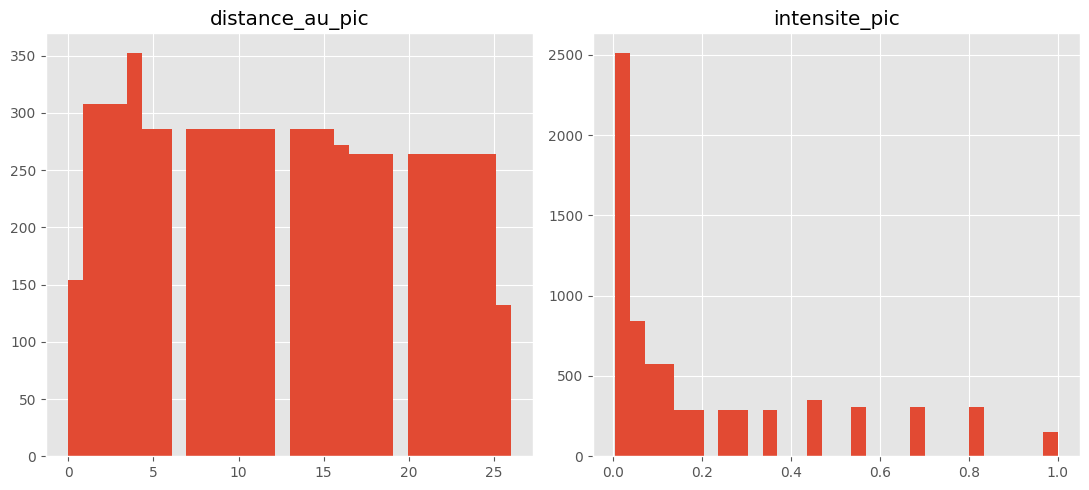

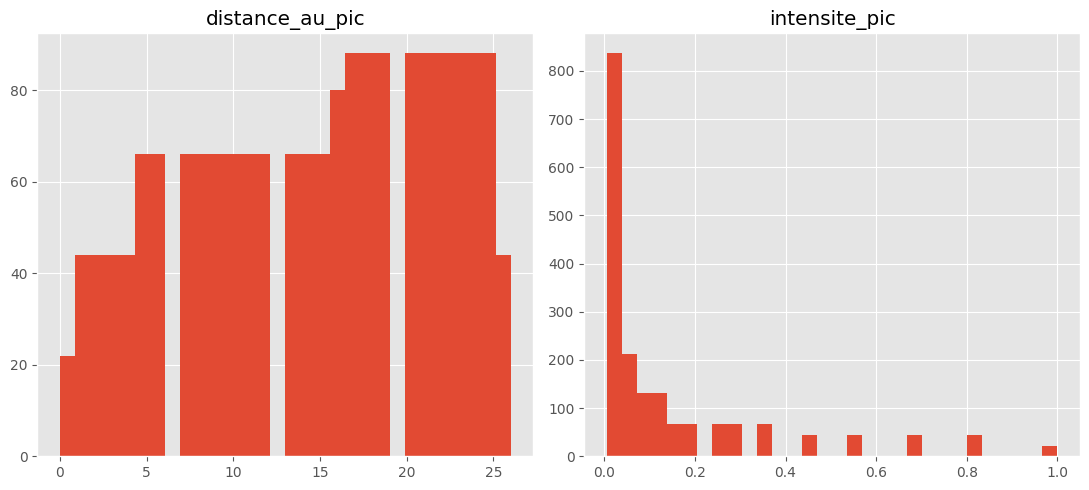

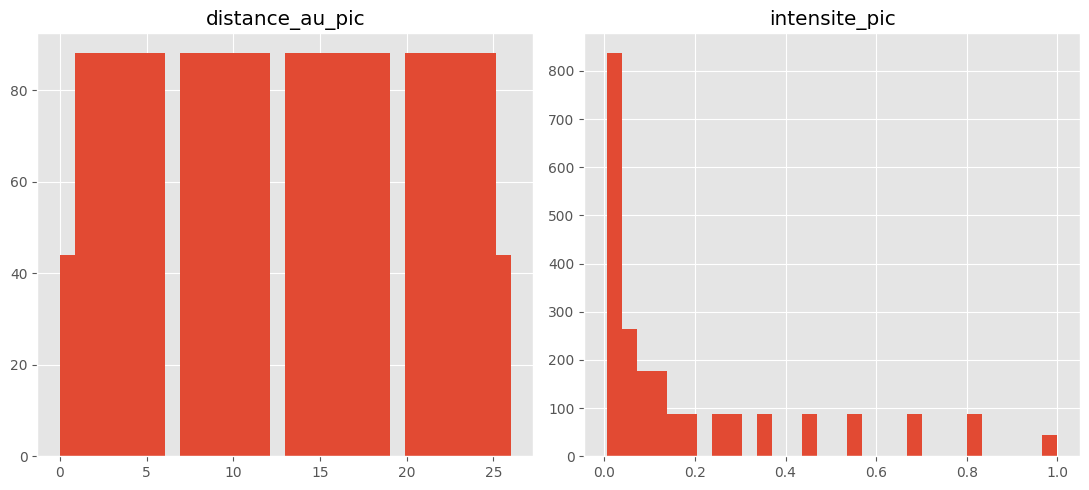

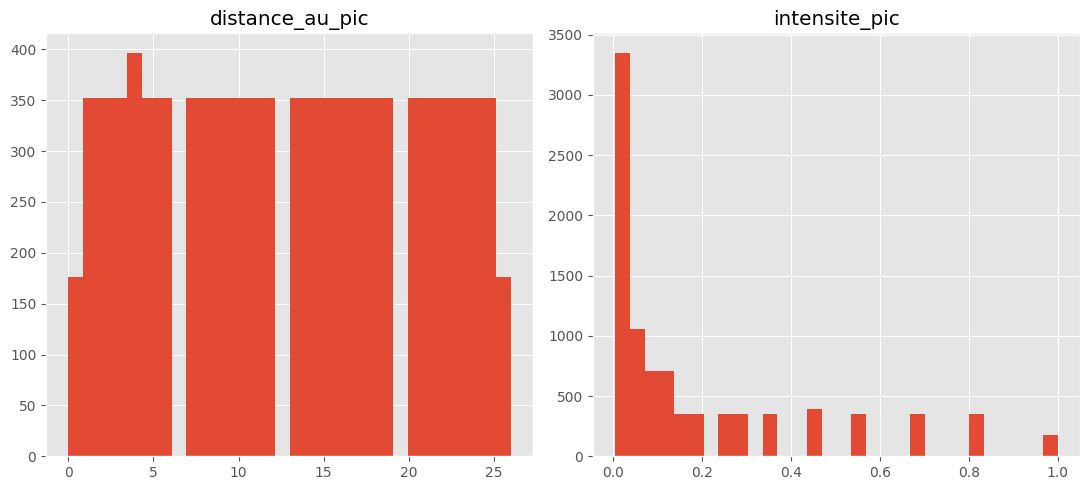

Nb des features : 63
['tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas', 'pres', 'tn12', 'tx12', 'tminsol', 'rafper', 'per', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 'requete_grippe_aviaire_vaccin', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie', 'week_num', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'est_phase_montante', 'est_pic_hivernal', 'est_phase_basse', 'distance_au_pic', 'intensite_pic', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75', 's_moyenne', 's_ecart_type', 's_mediane', 'r_moyenne', 'r_ecart_type', 'rs_eiq', 'rs_vs_s', 'froid', 'google_log', 'google_anomalie', 'google_rs', 'google_s', 'google_anom_rs', 'region_encodee']


In [11]:
# Application de l'ingénierie des caractéristiques
caract_train = feature_eng(donnees_train, donnees_train)
caract_val = feature_eng(donnees_val, donnees_train)
caract_test = feature_eng(df_test, df_train)
caract_complet = feature_eng(df_train, df_train)

variables_exclues = ['Id', 'Id_google',
                     'week', 'mois', 'annee', 
                     'TauxGrippe', 'TauxGrippe_google',
                     'region_name', 'region_code', 'franche_comte_impute', 'requete_grippe'
                     ]

features = []

for col in caract_train.columns:
    if col not in variables_exclues:
        if caract_train[col].dtype in ['float64', 'int64']:
            features.append(col)

print(f"Nb des features : {len(features)}")
print(features)

On observe que la distance au pic est répartie de façon assez homogène sur l’année, tandis que l’intensité du pic est fortement concentrée près de zéro (0-0,05).

- La saisonnalité normale - peu de semaines proches du pic et beaucoup de semaines avec une intensité faible.

- Features : 'tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'n', 'nbas', 'hbas', 'pres', 'tn12', 'tx12', 'tminsol', 'rafper', 'per', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'pop_0_19', 'pop_20_39', 'pop_40_59', 'pop_60_74', 'pop_75_plus', 'pop_total', 'requete_grippe_aviaire_vaccin', 'requete_grippe_aviaire_vaccin_porcine_porc_H1N1_AH1N1_A_mexicaine_Mexique_pandemie', 'week_num', 'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3', 'est_phase_montante', 'est_pic_hivernal', 'est_phase_basse', 'distance_au_pic', 'intensite_pic', 'rs_moyenne', 'rs_ecart_type', 'rs_mediane', 'rs_q25', 'rs_q75', 's_moyenne', 's_ecart_type', 's_mediane', 'r_moyenne', 'r_ecart_type', 'rs_eiq', 'rs_vs_s', 'froid', 'google_log', 'google_anomalie', 'google_rs', 'google_s', 'google_anom_rs', 'region_encodee'.

In [12]:
# Data prep train/val/test
X_train = caract_train[features]
y_train = caract_train['TauxGrippe']
X_val = caract_val[features]
y_val = caract_val['TauxGrippe']
X_complet = caract_complet[features]
y_complet = caract_complet['TauxGrippe']
X_test = caract_test[features]


### **Matrice de corrélation pour des nouveaux features**

In [13]:
# Sélection des 15 variables les plus corrélées avec tx de grippe
correlations = caract_train[features+['TauxGrippe']].corr()['TauxGrippe'].abs()
top_variables = correlations.nlargest(15).index.tolist() 
top_variables.remove('TauxGrippe')

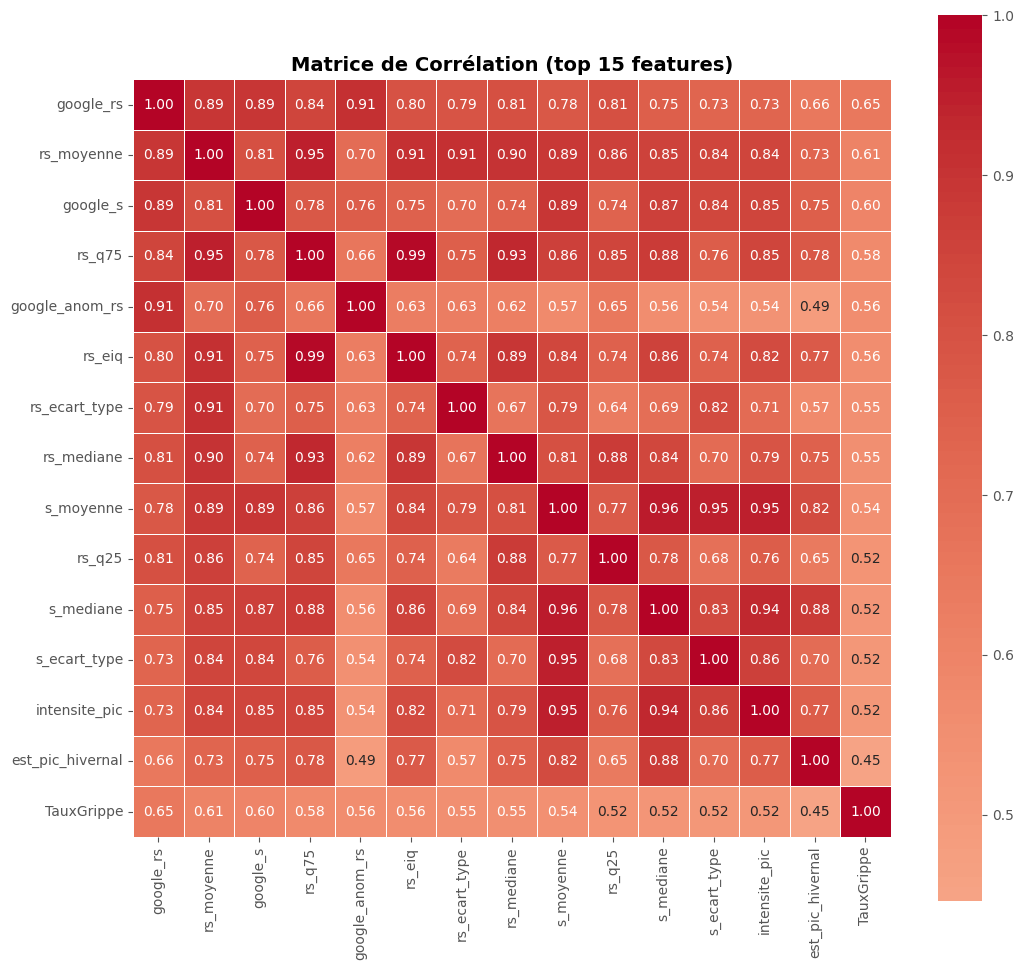

Features les plus corrélées avec TauxGrippe :
google_rs : 0.6549191755590246
rs_moyenne : 0.6101421616955757
google_s : 0.600755229868
rs_q75 : 0.5767138992626283
google_anom_rs : 0.558816652460638
rs_eiq : 0.5567978009524531
rs_ecart_type : 0.5549389748016192
rs_mediane : 0.5482860310127378
s_moyenne : 0.54207407664194
rs_q25 : 0.5246686838527702
s_mediane : 0.5194983519509269
s_ecart_type : 0.515554053388111
intensite_pic : 0.515285890001135
est_pic_hivernal : 0.44606944580114355


In [14]:
matrice_corr = caract_train[top_variables+['TauxGrippe']].corr()

plt.figure(figsize=(11, 10))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=0.5
)
plt.title('Matrice de Corrélation (top 15 features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Features les plus corrélées avec TauxGrippe :")
for i, var in enumerate(top_variables[:15], 1):
    corr_val = correlations[var]
    print(f"{var} : {corr_val}")

On verra sur le plot d'importance si ces variables contribuent le plus au modèle.

## **ÉTAPE 1: OPTUNA TUNING**

Approche :
5 sets de paramètres
- LightGBM: top-2
- XGBoost: top-2
- CatBoost: top-1

-----

## **1.1 LightGBM (30 trials)**

In [15]:
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_estimators': 500,
        'verbose': -1
    }
    
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    return rmse(y_val, preds)

study_lgb = optuna.create_study(direction='minimize', study_name='lgb')
study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)

print(f"RMSE: {study_lgb.best_value:.2f}")

Best trial: 11. Best value: 100.051: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]

RMSE: 100.05


## **1.2 XGBoost (30 trials)**

In [16]:
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'n_estimators': 500,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    return rmse(y_val, preds)

study_xgb = optuna.create_study(direction='minimize', study_name='xgb')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"RMSE: {study_xgb.best_value:.2f}")

Best trial: 26. Best value: 99.4175: 100%|██████████| 30/30 [01:06<00:00,  2.23s/it]

RMSE: 99.42


## **1.3 CatBoost (40 trials)**

In [17]:
def objective_cb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_seed': 42,
        'iterations': 500,
        'verbose': 0
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    return rmse(y_val, preds)

study_cb = optuna.create_study(direction='minimize', study_name='cb')
study_cb.optimize(objective_cb, n_trials=40, show_progress_bar=True)

print(f"RMSE: {study_cb.best_value:.2f}")

Best trial: 38. Best value: 97.087: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it] 

RMSE: 97.09


In [18]:
# Récupérer top-2 pour LGB et XGB, top-1 pour CB
lgb_trials = sorted(study_lgb.trials, key=lambda t: t.value)[:2]
xgb_trials = sorted(study_xgb.trials, key=lambda t: t.value)[:2]
cb_trials = sorted(study_cb.trials, key=lambda t: t.value)[:1]

all_params = {
    'lgb_v1': lgb_trials[0].params,
    'lgb_v2': lgb_trials[1].params if len(lgb_trials)>1 else lgb_trials[0].params,
    'xgb_v1': xgb_trials[0].params,
    'xgb_v2': xgb_trials[1].params if len(xgb_trials)>1 else xgb_trials[0].params,
    'cb_v1': cb_trials[0].params
}

## **LEVEL 1 STACKING**

Approche :
- 7-fold CV pour générer : Out-Of-Fold predictions pour train
- Averaged predictions pour test
- 5 modèles: LGB_v1, LGB_v2, XGB_v1, XGB_v2, CB_v1
----

In [19]:
n_folds = 7
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Stockage pour Level 1
level1_train = pd.DataFrame()
level1_test = pd.DataFrame()
oof_scores = {}

## **2.1 LightGBM v1**

In [20]:
oof_preds = np.zeros(len(X_complet))
test_preds = np.zeros(len(X_test))

params = all_params['lgb_v1'].copy()
params.update({'random_state': 42, 'n_estimators': 500, 'verbose': -1})

for fold, (train_idx, val_idx) in enumerate(kf.split(X_complet), 1):
    X_tr, X_vl = X_complet.iloc[train_idx], X_complet.iloc[val_idx]
    y_tr, y_vl = y_complet.iloc[train_idx], y_complet.iloc[val_idx]
    
    model = LGBMRegressor(**params)
    model.fit(X_tr, y_tr)
    
    oof_preds[val_idx] = model.predict(X_vl)
    test_preds += model.predict(X_test) / n_folds
    print(f"Fold {fold}/{n_folds} OK")

oof_rmse = rmse(y_complet, oof_preds)
oof_scores['lgb_v1'] = oof_rmse
level1_train['lgb_v1'] = oof_preds
level1_test['lgb_v1'] = test_preds

print(f"LGB_v1 OOF RMSE: {oof_rmse:.2f}")

Fold 1/7 OK
Fold 2/7 OK
Fold 3/7 OK
Fold 4/7 OK
Fold 5/7 OK
Fold 6/7 OK
Fold 7/7 OK
LGB_v1 OOF RMSE: 112.08


## **2.2 LightGBM v2**

In [21]:
oof_preds = np.zeros(len(X_complet))
test_preds = np.zeros(len(X_test))

params = all_params['lgb_v2'].copy()
params.update({'random_state': 42, 'n_estimators': 500, 'verbose': -1})

for fold, (train_idx, val_idx) in enumerate(kf.split(X_complet), 1):
    X_tr, X_vl = X_complet.iloc[train_idx], X_complet.iloc[val_idx]
    y_tr, y_vl = y_complet.iloc[train_idx], y_complet.iloc[val_idx]
    
    model = LGBMRegressor(**params)
    model.fit(X_tr, y_tr)
    
    oof_preds[val_idx] = model.predict(X_vl)
    test_preds += model.predict(X_test) / n_folds
    print(f"Fold {fold}/{n_folds} OK")

oof_rmse = rmse(y_complet, oof_preds)
oof_scores['lgb_v2'] = oof_rmse
level1_train['lgb_v2'] = oof_preds
level1_test['lgb_v2'] = test_preds

print(f"LGB_V2 OOF RMSE: {oof_rmse:.2f}")

Fold 1/7 OK
Fold 2/7 OK
Fold 3/7 OK
Fold 4/7 OK
Fold 5/7 OK
Fold 6/7 OK
Fold 7/7 OK
LGB_V2 OOF RMSE: 111.37


## **2.3 XGBoost v1**

In [22]:
oof_preds = np.zeros(len(X_complet))
test_preds = np.zeros(len(X_test))

params = all_params['xgb_v1'].copy()
params.update({'random_state': 42, 'n_estimators': 500, 'verbosity': 0})

for fold, (train_idx, val_idx) in enumerate(kf.split(X_complet), 1):
    X_tr, X_vl = X_complet.iloc[train_idx], X_complet.iloc[val_idx]
    y_tr, y_vl = y_complet.iloc[train_idx], y_complet.iloc[val_idx]
    
    model = XGBRegressor(**params)
    model.fit(X_tr, y_tr)
    
    oof_preds[val_idx] = model.predict(X_vl)
    test_preds += model.predict(X_test) / n_folds
    print(f"Fold {fold}/{n_folds} OK")

oof_rmse = rmse(y_complet, oof_preds)
oof_scores['xgb_v1'] = oof_rmse
level1_train['xgb_v1'] = oof_preds
level1_test['xgb_v1'] = test_preds

print(f"XGB_V1 OOF RMSE: {oof_rmse:.2f}")

Fold 1/7 OK
Fold 2/7 OK
Fold 3/7 OK
Fold 4/7 OK
Fold 5/7 OK
Fold 6/7 OK
Fold 7/7 OK
XGB_V1 OOF RMSE: 104.78


## **2.4 XGBoost v2**

In [23]:
oof_preds = np.zeros(len(X_complet))
test_preds = np.zeros(len(X_test))

params = all_params['xgb_v2'].copy()
params.update({'random_state': 42, 'n_estimators': 500, 'verbosity': 0})

for fold, (train_idx, val_idx) in enumerate(kf.split(X_complet), 1):
    X_tr, X_vl = X_complet.iloc[train_idx], X_complet.iloc[val_idx]
    y_tr, y_vl = y_complet.iloc[train_idx], y_complet.iloc[val_idx]
    
    model = XGBRegressor(**params)
    model.fit(X_tr, y_tr)
    
    oof_preds[val_idx] = model.predict(X_vl)
    test_preds += model.predict(X_test) / n_folds
    print(f"Fold {fold}/{n_folds} OK")

oof_rmse = rmse(y_complet, oof_preds)
oof_scores['xgb_v2'] = oof_rmse
level1_train['xgb_v2'] = oof_preds
level1_test['xgb_v2'] = test_preds

print(f"XGB_V2 OOF RMSE: {oof_rmse:.2f}")

Fold 1/7 OK
Fold 2/7 OK
Fold 3/7 OK
Fold 4/7 OK
Fold 5/7 OK
Fold 6/7 OK
Fold 7/7 OK
XGB_V2 OOF RMSE: 104.16


## **2.5 CatBoost v1**

In [ ]:
oof_preds = np.zeros(len(X_complet))
test_preds = np.zeros(len(X_test))

params = all_params['cb_v1'].copy()
params.update({'random_state': 42, 'n_estimators': 500, 'verbose': 0})

for fold, (train_idx, val_idx) in enumerate(kf.split(X_complet), 1):
    X_tr, X_vl = X_complet.iloc[train_idx], X_complet.iloc[val_idx]
    y_tr, y_vl = y_complet.iloc[train_idx], y_complet.iloc[val_idx]
    
    model = CatBoostRegressor(**params)
    model.fit(X_tr, y_tr)
    
    oof_preds[val_idx] = model.predict(X_vl)
    test_preds += model.predict(X_test) / n_folds
    print(f"Fold {fold}/{n_folds} OK")

oof_rmse = rmse(y_complet, oof_preds)
oof_scores['cb_v1'] = oof_rmse
level1_train['cb_v1'] = oof_preds
level1_test['cb_v1'] = test_preds

print(f"CB_V1 OOF RMSE: {oof_rmse:.2f}")


🚀 Training CB_V1...
   Fold 1/7 done
   Fold 2/7 done
   Fold 3/7 done
   Fold 4/7 done
   Fold 5/7 done
   Fold 6/7 done
   Fold 7/7 done
✅ CB_V1 OOF RMSE: 111.30


In [24]:
print("OOF RMSE Scores:")
for model, score in oof_scores.items():
    print(f"{model}: {score:.2f}")

best_model = min(oof_scores, key=oof_scores.get)

print(f"Top Modèle : {best_model} ({oof_scores[best_model]:.2f})")

OOF RMSE Scores:
lgb_v1: 112.08
lgb_v2: 111.37
xgb_v1: 104.78
xgb_v2: 104.16
Top Modèle : xgb_v2 (104.16)


# **LEVEL 2 : RIDGE META-LEARNER**

**Méta-Model**: Ridge Regression sur les prédictions Level 1


------

In [25]:
# Données Level 2
X_level2_train = level1_train.values
y_level2 = y_complet.values
X_level2_test = level1_test.values

# Ridge avec CV
kf_l2 = KFold(n_splits=5, shuffle=True, random_state=42)
oof_level2 = np.zeros(len(y_level2))

for train_idx, val_idx in kf_l2.split(X_level2_train):
    X_tr, X_vl = X_level2_train[train_idx], X_level2_train[val_idx]
    y_tr, y_vl = y_level2[train_idx], y_level2[val_idx]
    
    ridge = Ridge(random_state=42)
    ridge.fit(X_tr, y_tr)
    oof_level2[val_idx] = ridge.predict(X_vl)

final_oof_rmse = rmse(y_level2, oof_level2)
print(f"LEVEL 2 OOF RMSE: {final_oof_rmse:.2f}")

# Ridge final sur tout
ridge_final = Ridge(random_state=42)
ridge_final.fit(X_level2_train, y_level2)
final_test_preds = ridge_final.predict(X_level2_test)

# Poids
print("Ridge Poids:")
for i, col in enumerate(level1_train.columns):
    print(f"   {col}: {ridge_final.coef_[i]:.4f}")
print(f"Intercept: {ridge_final.intercept_:.2f}")

# Meilleur Level 1
best_model = min(oof_scores, key=oof_scores.get)
print(f"Top Level 1 : {best_model} ({oof_scores[best_model]:.2f})")
print(f"Amélioration : {oof_scores[best_model] - final_oof_rmse:.2f} RMSE")

LEVEL 2 OOF RMSE: 103.94
Ridge Poids:
   lgb_v1: -0.0979
   lgb_v2: -0.1591
   xgb_v1: 0.4703
   xgb_v2: 0.8408
Intercept: -2.33
Top Level 1 : xgb_v2 (104.16)
Amélioration : 0.21 RMSE


## **SHAP Values**


--------

In [34]:
# Entraînement d'un modèle CatBoost
params_shap = all_params['cb_v1'].copy()
params_shap.update({'random_seed': 42, 'iterations': 500, 'verbose': 0})

model_shap = CatBoostRegressor(**params_shap)
model_shap.fit(X_train, y_train)


In [35]:
n_samples = min(200, len(X_val))
sample_idx = np.random.choice(len(X_val), size=n_samples, replace=False)
X_shap = X_val.iloc[sample_idx]

In [ ]:
# CatBoost SHAP nécessite pool object
shap_pool = Pool(X_shap)

shap_raw = model_shap.get_feature_importance(data=shap_pool, type='ShapValues')

# Séparer values et base_values
shap_vals = shap_raw[:, :-1]
shap_base = shap_raw[:, -1]


shap_exp = shap.Explanation(values=shap_vals, base_values=shap_base, data=X_shap.values, feature_names=X_shap.columns.tolist())

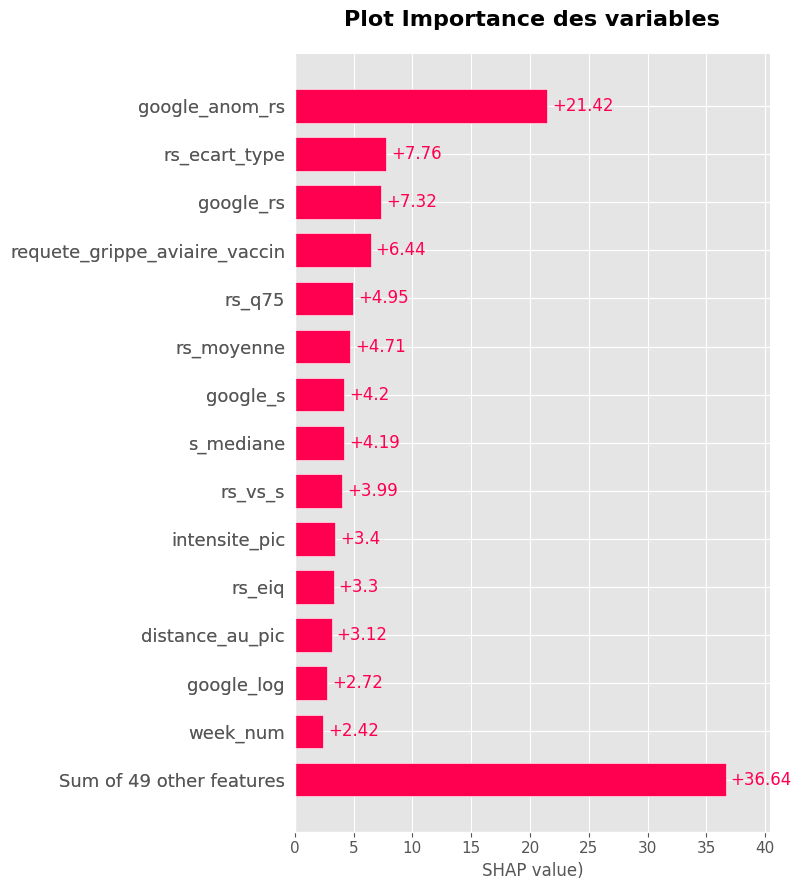

In [39]:
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_exp, max_display=15, show=False)
plt.title('Plot Importance des variables', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP value)', fontsize=12)
plt.tight_layout()

plt.show()

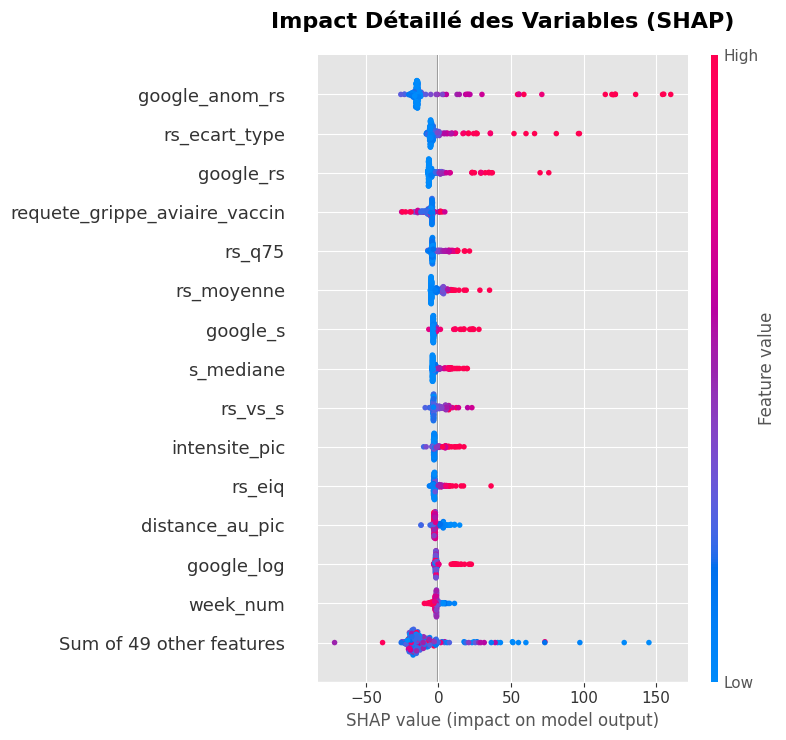

✅ Graphique 2 sauvegardé: shap_beeswarm.png


In [ ]:
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_exp, max_display=15, show=False)
plt.title('Impact Détaillé des Variables (SHAP)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP value', fontsize=12)
plt.tight_layout()
plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')

plt.show()

In [44]:
importance_df = pd.DataFrame({'Feature': X_shap.columns, 'Mean_|SHAP|': np.abs(shap_vals).mean(axis=0)}).sort_values('Mean_|SHAP|', ascending=False)

print("TOP 15 FEATURES :")
for idx, row in importance_df.head(15).iterrows():
    print(f"  {idx+1:2d}. {row['Feature']:35s} {row['Mean_|SHAP|']:6.2f}")

TOP 15 FEATURES :
  62. google_anom_rs                       21.42
  46. rs_ecart_type                         7.76
  60. google_rs                             7.32
  31. requete_grippe_aviaire_vaccin         6.44
  49. rs_q75                                4.95
  45. rs_moyenne                            4.71
  61. google_s                              4.20
  52. s_mediane                             4.19
  56. rs_vs_s                               3.99
  44. intensite_pic                         3.40
  55. rs_eiq                                3.30
  43. distance_au_pic                       3.12
  58. google_log                            2.72
  33. week_num                              2.42
  20. rr1                                   2.27


**Rappel : Features les plus corrélées avec TauxGrippe**
- google_rs : 0.6549256931345007
- rs_moyenne : 0.61015060603583
- google_s : 0.6007650640350591
- rs_q75 : 0.5767269395493568
- google_anom_rs : 0.558821980701418
- rs_eiq : 0.5568102188331396
- rs_ecart_type : 0.5549491641028331
- rs_mediane : 0.5482856953803031
- s_moyenne : 0.5420863645398123
- rs_q25 : 0.524687847472434
- s_mediane : 0.5195074497914585
- s_ecart_type : 0.515568251038898
- intensite_pic : 0.5152964827953966
- est_pic_hivernal : 0.44607370983606504

## **Résumé**

--------

In [45]:
print(f"Résultats:")
print("OOF Scores:")
for model, score in oof_scores.items():
    print(f"{model}: {score:.2f}")
print(f"RIDGE : {final_oof_rmse:.2f} ")

Résultats:
OOF Scores:
lgb_v1: 112.08
lgb_v2: 111.37
xgb_v1: 104.78
xgb_v2: 104.16
RIDGE : 103.94 


## **CSV Submission**

--------

In [46]:
# Clip et créer submission
final_preds_clipped = np.clip(final_test_preds, 0, None)

submission = pd.DataFrame({'Id': caract_test['Id'].astype(int), 'TauxGrippe': final_preds_clipped}).sort_values('Id').reset_index(drop=True)
submission.to_csv('soumission_modele_meta_finale.csv', index=False)